In [1]:
import netCDF4 as nc
import numpy as np
from SoilTools import BrooksCorey as BC
from SoilTools import VanGenuchten as VG
from SoilTools import Thermal as TH


In [2]:
Input_Dir='/users/eow/edwcom/GREENHOUSE/SOIL_PROPERTIES/datasets/'
Comp_File=Input_Dir+'Merged_Soil_WeightedComposition_CHESSgrid.nc'

Output_Dir=Input_Dir
OUT_BC_file=Output_Dir+'Merged_Soil_WeightedComposition_BCproperties.nc'
OUT_VG_file=Output_Dir+'Merged_Soil_WeightedComposition_VGproperties.nc'


CHESS_landcover_file='/users/eow/edwcom/CHESS/chess_landcover_2000.nc'


In [3]:
#help(VG.get_VG_soil_props_from_comp)

In [4]:
fill_value=-9999.
Soil_Layer_Thick=np.array([0.1,0.25,0.65,2.0])   #(metres)
Soil_Layer_Depth=np.array([0.1,0.23,1.0,3.0]) #(metres)
nSD=len(Soil_Layer_Thick)

In [5]:
#read in latlon/xy data from chess_landcover
LLinf=nc.Dataset(CHESS_landcover_file,'r')
landcover=LLinf.variables['frac'][:]
LLinf.close()
LAND_MASK=landcover.mask[0,:]

In [6]:
# Read Soil Composition File
INPUT_vars=['sand','silt','clay','org_carb']
COMP_data={}
COMPinf=nc.Dataset(Comp_File,'r')
for var in INPUT_vars:
    COMP_data[var]=COMPinf.variables[var][:]
#COMPinf.close()


In [7]:

# Compute the Brooks and Corey Soil Properties
BC_Properties=BC.get_BC_soil_properties(COMP_data['clay'],\
                                        COMP_data['sand'],\
                                        COMP_data['silt'] )

BC_Properties['hcap']=TH.hcap(COMP_data['clay'],\
                              COMP_data['sand'],\
                              COMP_data['silt'] )

BC_Properties['hcon']=TH.hcon_Farouki(COMP_data['clay'],\
                                      COMP_data['sand'],\
                                      COMP_data['silt'] )



In [10]:
import pylab as plt


In [15]:
ax=plt.subplot(1,2,1)
ax.hist(BC_Properties['sm_sat'].flatten())
ax=plt.subplot(1,2,2)
ax.hist(BC_Properties['sm_crit'].flatten())
plt.show()

In [13]:
plt.show()

In [8]:
# Output BC data
outf=nc.Dataset(OUT_BC_file,'w')

# create dimensions
for dim in COMPinf.dimensions:
    outf.createDimension(str(dim),len(COMPinf.dimensions[dim]))
    outvar=outf.createVariable(str(dim),'float32',str(dim))
    for att in COMPinf.variables[dim].ncattrs():
        outvar.setncattr(str(att),COMPinf.variables[dim].getncattr(str(att)))
    outvar[:]=COMPinf.variables[dim][:]

for var in BC_Properties:
    outvar=outf.createVariable(str(var),'float32',('z','y','x'))
    outvar[:]=BC_Properties[var]

outf.Title='Brooks and Corey Soil Properties on the British National Grid'
outf.datasource1='Cranfield Soil data for England and Wales'
outf.datasource2='Scotland Soils data for Scotland'
outf.method='Created using pedotransfer functions'
outf.creator='Edward Comyn-Platt (edwcom@ceh.ac.uk)'
outf.organisation='Centre of Ecology and Hydrology, Wallingford'

outf.close()

In [9]:

SUB_SOIL=np.ones_like(COMP_data['clay'].data,dtype=bool)
SUB_SOIL[0,:]=False


In [10]:

# Compute the Van Genuchten Soil Properties
VG_Properties=VG.get_VG_soil_props_from_comp(COMP_data['clay'],          \
                                             COMP_data['sand'],          \
                                             COMP_data['silt'],          \
                                             OC_PC=COMP_data['org_carb'],\
                                             SUB_SOIL=SUB_SOIL,          \
                                             RETURN_SOIL_TEXTURE=True,   \
                                            )


VG_Properties['hcap']=TH.hcap(COMP_data['clay'],\
                              COMP_data['sand'],\
                              COMP_data['silt'],\
                              sm_sat=VG_Properties['sm_sat'], \
                              l_vg=True         )

VG_Properties['hcon']=TH.hcon_Farouki(COMP_data['clay'],\
                                      COMP_data['sand'],\
                                      COMP_data['silt'],\
                                      sm_sat=VG_Properties['sm_sat'], \
                                      l_vg=True         )


/users/eow/edwcom/miniconda3/lib/python3.5/site-packages/numpy/ma/core.py:3878: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  check = self.filled(0).__ne__(other)
/users/eow/edwcom/miniconda3/lib/python3.5/site-packages/numpy/ma/core.py:3842: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  check = self.filled(0).__eq__(other)


In [11]:
VG_Properties['Soil_Texture']=VG_Properties['Soil_Texture'].astype(float)

# Output VG data
outf=nc.Dataset(OUT_VG_file,'w')

# create dimensions
for dim in COMPinf.dimensions:
    outf.createDimension(str(dim),len(COMPinf.dimensions[dim]))
    outvar=outf.createVariable(str(dim),'float32',str(dim))
    for att in COMPinf.variables[dim].ncattrs():
        outvar.setncattr(str(att),COMPinf.variables[dim].getncattr(str(att)))
    outvar[:]=COMPinf.variables[dim][:]

for var in VG_Properties:
    outvar=outf.createVariable(str(var),'float32',('z','y','x'))
    outvar[:]=VG_Properties[var]

outf.Title='Van Genuchten Soil Properties on the British National Grid'
outf.datasource1='Cranfield Soil data for England and Wales'
outf.datasource2='Scotland Soils data for Scotland'
outf.method='Created using pedotransfer functions'
outf.creator='Edward Comyn-Platt (edwcom@ceh.ac.uk)'
outf.organisation='Centre of Ecology and Hydrology, Wallingford'

outf.close()

In [12]:
#outf.close()

In [13]:

import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize']=(20,10)



In [16]:
iSD=0


plt.figure(figsize=(10,10))
plotdata=Soil_Texture
plt.imshow(plotdata[iSD,:],origin='bottom')
plt.colorbar()

plt.figure(figsize=(30,10))
plt.subplot(1,3,1)
plotdata=COMP_data['sand']
plt.imshow(plotdata[iSD,:],origin='bottom')
plt.colorbar()
plt.subplot(1,3,2)
plotdata=COMP_data['silt']
plt.imshow(plotdata[iSD,:],origin='bottom')
plt.colorbar()
plt.subplot(1,3,3)
plotdata=COMP_data['clay']
plt.imshow(plotdata[iSD,:],origin='bottom')
plt.colorbar()


NameError: name 'Soil_Texture' is not defined

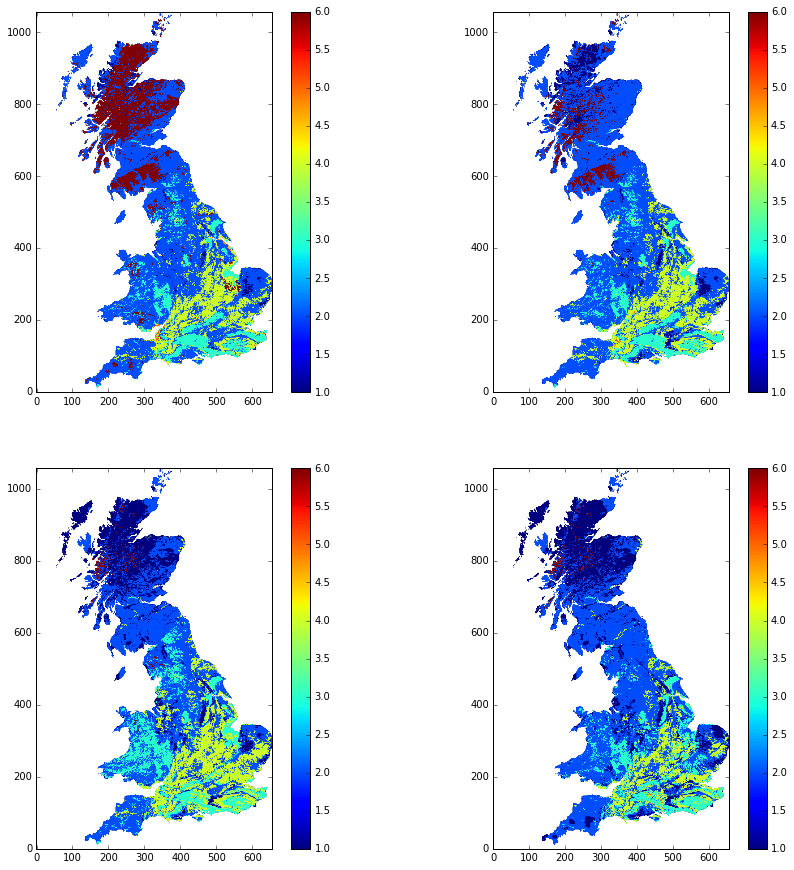

In [14]:

plotdata=VG_Properties['Soil_Texture']

plt.figure(figsize=(15,15))
for iSD in range(4):
    plt.subplot(2,2,iSD+1)
    plt.imshow(plotdata[iSD,:],origin='bottom')
    plt.colorbar()



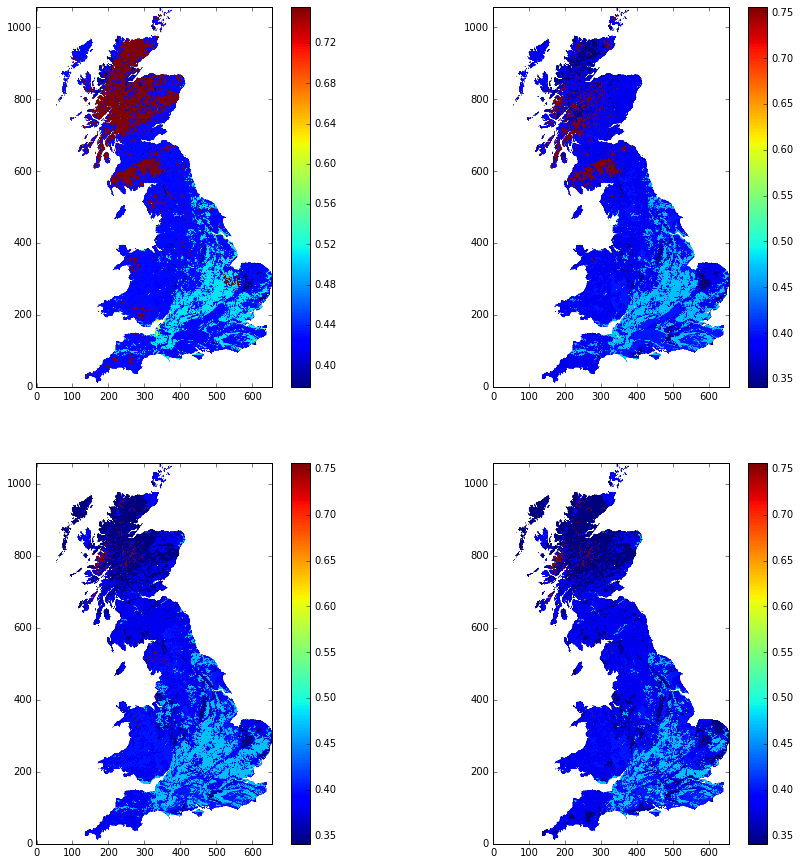

In [15]:

plotdata=VG_Properties['sm_sat']

plt.figure(figsize=(15,15))
for iSD in range(4):
    plt.subplot(2,2,iSD+1)
    plt.imshow(plotdata[iSD,:],origin='bottom')
    plt.colorbar()



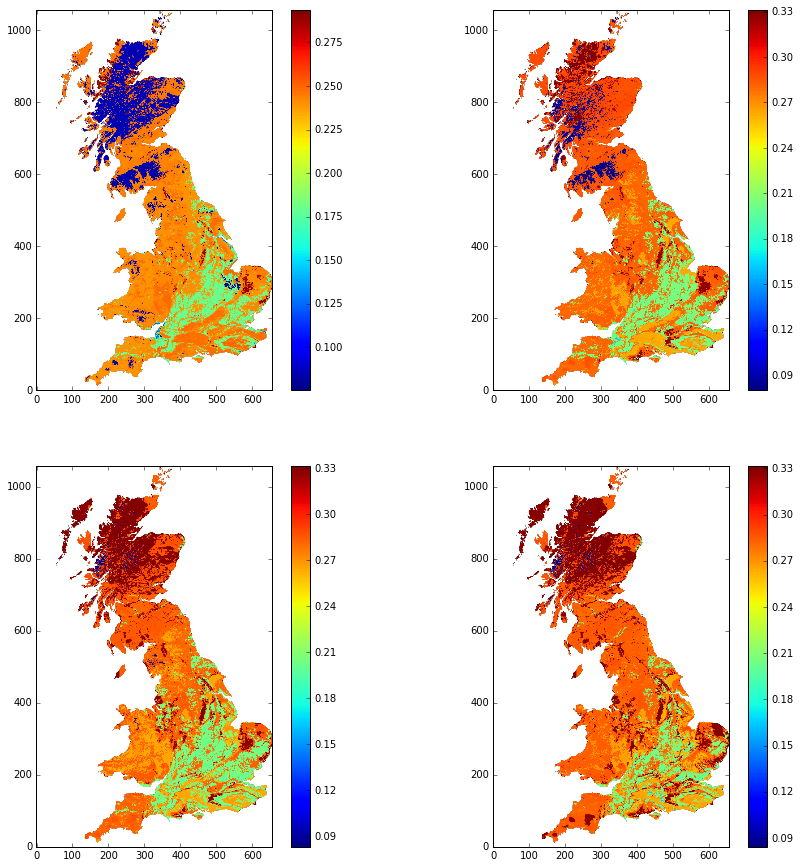

In [16]:

plotdata=VG_Properties['hcon']

plt.figure(figsize=(15,15))
for iSD in range(4):
    plt.subplot(2,2,iSD+1)
    plt.imshow(plotdata[iSD,:],origin='bottom')
    plt.colorbar()

